In [1]:
import pandas as pd
import os
import csv
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
import networkx as nx
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import pandas as pd
from gensim.models import Word2Vec

In [2]:
graph = nx.read_gml('no_relations_graph.gml')
node_subjects = nx.get_node_attributes(graph,'table_name')

In [3]:
index_list = [*range(0, 2420, 1)] 
node_subjects= pd.Series(list(node_subjects.values()), index = index_list, name= "table_name")
print(node_subjects)

0       classroom
1       classroom
2       classroom
3       classroom
4       classroom
          ...    
2415    time_slot
2416    time_slot
2417    time_slot
2418    time_slot
2419    time_slot
Name: table_name, Length: 2420, dtype: object


In [4]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.8, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [5]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [6]:
def convertTheTypes(df_read):
    df = df_read.astype({"index": "int64"})
    as_list = df_read.value.to_list()
    #print(as_list)
    for i in range(0,len(df_read)):
        string_holder = as_list[i].replace(",","")
        #np.fromstring(string_holder[1:len(string_holder)-1], dtype=float, sep=' ')
        df['value'][i] = np.fromstring(string_holder[1:len(string_holder)-1], dtype=float, sep=' ')
    return df

In [7]:
holder = 0
list_valid= [1,2,3,4,5]
while holder not in list_valid:
    print("Select the type of feature vector representation of every node:\n1) One Hot Encoding \n2) Doc2Vec\n3) Word2Vec\n4) TF-IDF\n5) Bow\n")
    holder= int(input())
    if holder == 1:
        matrix=[]
        for i in range(0,len(node_subjects)):
            vecForEach = np.zeros(len(node_subjects)) 
            vecForEach[i] = 1
            matrix.append(vecForEach)

        index = [*range(0,len(node_subjects),1)]
        list_of_tuples = list(zip(index, matrix))
        df = pd.DataFrame(list_of_tuples, 
                  columns = ['index', 'value'])   
    if holder == 2:
        df_read = pd.read_csv('output_doc2vec.csv')
        df = convertTheTypes(df_read)
    if holder == 3:
        df_read = pd.read_csv('output_word2vec.csv')
        df = convertTheTypes(df_read)        
    if holder == 4:
        df_read = pd.read_csv('output_tfidf.csv')
        df = convertTheTypes(df_read)        
    if holder == 5:
        df_read = pd.read_csv('output_bow.csv')
        df = convertTheTypes(df_read)

Select the type of feature vector representation of every node:
1) One Hot Encoding 
2) Doc2Vec
3) Word2Vec
4) TF-IDF
5) Bow

1


In [8]:
#add w2v_df value to corresponding node in the graph
i=0
for u,outer_d in graph.nodes(data=True):
    #print(type(df.iloc[i]['value']))
    outer_d['val'] = df.iloc[i]['value']
    i+=1

In [9]:
G = sg.StellarGraph.from_networkx(graph,node_features="val")
G.info()

'StellarGraph: Undirected multigraph\n Nodes: 2420, Edges: 34548\n\n Node types:\n  default: [2420]\n    Features: float32 vector, length 2420\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [34548]\n        Weights: all 1 (default)\n        Features: none'

In [10]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [11]:
train_gen = generator.flow(train_subjects.index, targets=train_targets, use_ilocs=True)   

In [12]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [13]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<tf.Tensor 'gather_indices/Identity:0' shape=(1, None, 16) dtype=float32>

In [14]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [15]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [16]:
val_gen = generator.flow(val_subjects.index, val_targets, use_ilocs=True)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [18]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/200
1/1 - 2s - loss: 1.9450 - acc: 0.4582 - val_loss: 1.9103 - val_acc: 0.8264
Epoch 2/200
1/1 - 0s - loss: 1.9102 - acc: 0.8295 - val_loss: 1.8703 - val_acc: 0.8264
Epoch 3/200
1/1 - 0s - loss: 1.8700 - acc: 0.8264 - val_loss: 1.8259 - val_acc: 0.8264
Epoch 4/200
1/1 - 0s - loss: 1.8281 - acc: 0.8264 - val_loss: 1.7770 - val_acc: 0.8264
Epoch 5/200
1/1 - 0s - loss: 1.7784 - acc: 0.8264 - val_loss: 1.7234 - val_acc: 0.8264
Epoch 6/200
1/1 - 0s - loss: 1.7234 - acc: 0.8264 - val_loss: 1.6650 - val_acc: 0.8264
Epoch 7/200
1/1 - 0s - loss: 1.6589 - acc: 0.8264 - val_loss: 1.6021 - val_acc: 0.8264
Epoch 8/200
1/1 - 0s - loss: 1.6008 - acc: 0.8264 - val_loss: 1.5349 - val_acc: 0.8264
Epoch 9/200
1/1 - 0s - loss: 1.5278 - acc: 0.8264 - val_loss: 1.4642 - val_acc: 0.8264
Epoch 10/200
1/1 - 0s - loss: 1.4536 - acc: 0.8264 - val_loss: 1.3910 - val_acc: 0.8264
Epoch 11/200
1/1 - 0s - loss: 1.3924 - 

Epoch 92/200
1/1 - 0s - loss: 0.0834 - acc: 0.9788 - val_loss: 0.1154 - val_acc: 0.9711
Epoch 93/200
1/1 - 0s - loss: 0.0834 - acc: 0.9793 - val_loss: 0.1142 - val_acc: 0.9711
Epoch 94/200
1/1 - 0s - loss: 0.0764 - acc: 0.9819 - val_loss: 0.1137 - val_acc: 0.9752
Epoch 95/200
1/1 - 0s - loss: 0.0871 - acc: 0.9783 - val_loss: 0.1140 - val_acc: 0.9669
Epoch 96/200
1/1 - 0s - loss: 0.0806 - acc: 0.9690 - val_loss: 0.1144 - val_acc: 0.9669
Epoch 97/200
1/1 - 0s - loss: 0.0888 - acc: 0.9700 - val_loss: 0.1150 - val_acc: 0.9711
Epoch 98/200
1/1 - 0s - loss: 0.0762 - acc: 0.9773 - val_loss: 0.1155 - val_acc: 0.9711
Epoch 99/200
1/1 - 0s - loss: 0.0684 - acc: 0.9804 - val_loss: 0.1159 - val_acc: 0.9752
Epoch 100/200
1/1 - 0s - loss: 0.0712 - acc: 0.9840 - val_loss: 0.1161 - val_acc: 0.9752
Epoch 101/200
1/1 - 0s - loss: 0.0734 - acc: 0.9840 - val_loss: 0.1154 - val_acc: 0.9752
Epoch 102/200
1/1 - 0s - loss: 0.0650 - acc: 0.9830 - val_loss: 0.1152 - val_acc: 0.9752
Epoch 103/200
1/1 - 0s - loss

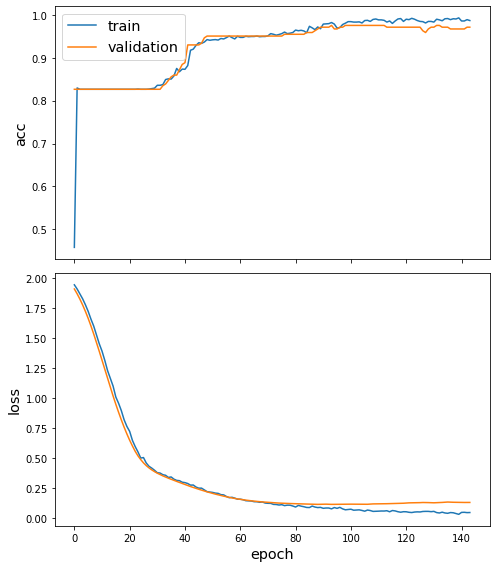

In [19]:
sg.utils.plot_history(history)

In [20]:
test_gen = generator.flow(test_subjects.index, test_targets,use_ilocs=True)

In [21]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ...
    to  
  ['...']
1/1 [==============================] - 0s 91ms/step - loss: 0.0895 - acc: 0.9669

Test Set Metrics:
	loss: 0.0895
	acc: 0.9669


In [22]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes,use_ilocs=True)
all_predictions = model.predict(all_gen)

In [23]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [24]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
0,classroom,classroom
1,classroom,classroom
2,course,classroom
3,course,classroom
4,classroom,classroom
5,course,classroom
6,course,classroom
7,course,classroom
8,course,classroom
9,classroom,classroom


In [25]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [26]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2420, 16)

In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

In [28]:
X = emb.squeeze(0)
X.shape

(2420, 16)

In [29]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2420, 2)

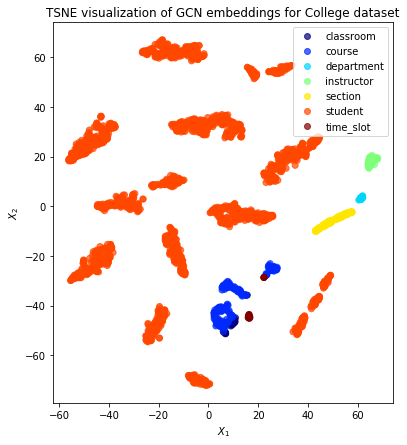

In [30]:
fig, ax = plt.subplots(figsize=(7, 7))
scatter =ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for College dataset",
)
classes = ['classroom', 'course','department','instructor','section', 'student','time_slot']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)